In [1]:
# Importing libraries for the datasets
import numpy as np
import time
import os
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader, random_split


cudnn.benchmark = True
plt.ion()   # interactive mode


In [ ]:
# Setting the device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps")

In [3]:
def dataset(sub_path, total_samples, images, labels, batch_size=16):
    sub_dataset = datasets.ImageFolder(root=sub_path, transform=transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()]))
    dataloader = DataLoader(sub_dataset, batch_size=batch_size, shuffle=False)

    for i, (batch_images, batch_labels) in enumerate(tqdm(dataloader)):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, total_samples)

        images[start_idx:end_idx] = np.transpose(batch_images.numpy(), (0, 2, 3, 1))
        labels[start_idx:end_idx] = batch_labels.numpy()

    return images, labels


In [4]:
# Load full dataset
path = "data_files/resized_images/"
transformations = transforms.Compose([transforms.Resize((300, 300)), transforms.ToTensor()])
population = datasets.ImageFolder(root=path, transform=transformations)
total_samples = len(population)
total_samples



332686

In [5]:
# Define the sizes for training and testing sets
train_size = int(0.8 * len(population))
test_size = len(population) - train_size

# Create training and testing datasets
train_dataset, test_dataset = random_split(population, [train_size, test_size])

In [6]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle =True )
val_loader = DataLoader(test_dataset, batch_size=16)

In [7]:
# Data augmentation and normalization for training
# Just normalization for validation

image_datasets = {'train': train_dataset,'val': test_dataset}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].dataset.classes

In [8]:
class_names

['AeliaFlacilla',
 'Agrippa',
 'Allectus',
 'AntoninusPius',
 'Arcadius',
 'Augustus',
 'Aurelian',
 'Caligula',
 'Caracalla',
 'Carausius',
 'Carinus',
 'Carus',
 'Claudius',
 'ClaudiusGothicus',
 'ClodiusAlbinus',
 'Commodus',
 'Constans',
 'ConstansII',
 'ConstantineI',
 'ConstantineII',
 'ConstantineIII',
 'ConstantiusChlorus',
 'ConstantiusGallus',
 'ConstantiusII',
 'Crispus',
 'Dalmatius',
 'Decentius',
 'Diadumenian',
 'Diocletian',
 'Domitian',
 'Elagabalus',
 'Eugenius',
 'FlaviusVictor',
 'Galba',
 'Galerius',
 'Gallienus',
 'Germanicus',
 'Geta',
 'GordianIII',
 'Gratian',
 'Hadrian',
 'Honorius',
 'Jovian',
 'Julian',
 'LeoI',
 'Licinius',
 'LiciniusII',
 'LuciusAeliusCaesar',
 'LuciusVerus',
 'Macrinus',
 'Magnentius',
 'MagnusMaximus',
 'Marcian',
 'MarcusAurelius',
 'Maxentius',
 'Maximian',
 'MaximinusDaia',
 'MaximinusI',
 'Maximus',
 'Nero',
 'Nerva',
 'Numerian',
 'PescenniusNiger',
 'PhilipII',
 'PhiliptheArab',
 'Postumus',
 'Probus',
 'Quintillus',
 'Romulus',
 '

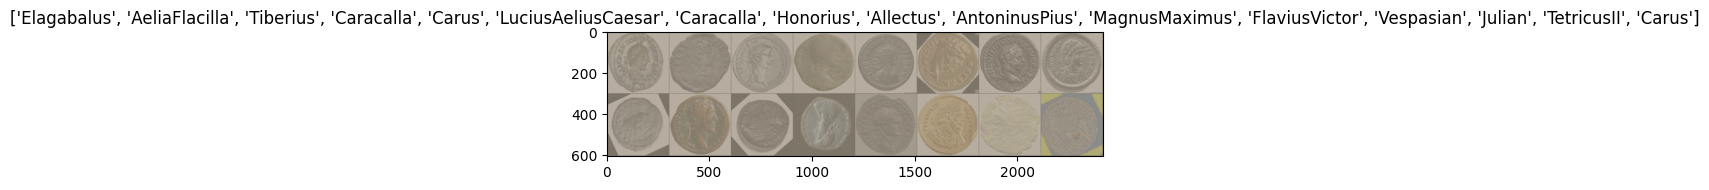

In [9]:
# Illustrating a batch for demonstration

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model, best_acc

In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [12]:
# Load a pretrained ResNet-18 model with weights from the ImageNet dataset
model_ft = models.resnet18(weights='IMAGENET1K_V1')
# Get the number of input features for the final fully connected layer
num_ftrs = model_ft.fc.in_features

# Replace the final fully connected layer with a new one
# The new layer will have an output size equal to the number of classes in the dataset
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

# Move the model to the specified device (GPU or CPU)
model_ft = model_ft.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
# Training the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


In [ ]:
# Saving the output
torch.save(model_ft, 'data_files/trained_models/imagenet_1_replace.pt')